In [ ]:
'''todo:
- write code that stops simulation if body runs into planet or sun
- write code into simulator that counts how many times the body is flung out, runs into planet, runs into sun, etc.
- figure out how to save simulation after it is done running (both as video and as final image)
- put figures of simulations on subplots 
- figure out what we'd like to display/conclude from our simulation (maybe we test existing ejection constants, 
figure out size of planet needed to clear orbit, etc.)
'''

# Clearing an Orbit
## A formal investigation into how Pluto tragically lost its planethood
### Collin Fitzpatrick, Alejandro Wang, Alan Wu

### Background
According to the International Astronomical Union, a celestial body must meet three criteria to be considered a planet.

1. It must orbit a star (in our cosmic neighborhood, the Sun). 
2. It must be big enough to have enough gravity to force it into a spherical shape. 
3. It must be big enough that its gravity cleared away any other objects of a similar size near its orbit around the Sun. 

### Goal
We would like to build a simulation that can model how a large planet object orbiting the sun interacts with smaller bodies in its path. 

Some questions we have include:
- How quickly is the orbit cleared?
- How big must the planet be relative to the bodies in order to clear the orbit?
- Where do the small bodies end up? As moons? Thrown out of solar system? Thrown into the planet or the sun?

### The Setup
**note that all variables with subscript j refer to the planet (as if it was jupiter)*

<img src="phys24ProjectImage.jpeg" alt="drawing" width="500"/>

From independent variables $r$, $r_j$, $\theta_1$, and $\theta_2$ we can derive expressions for the distance $s$ between the orbiting bodies and the angle $\theta_3$ between the planet and the sun with the small body at the vertex.

Using the law of cosines,
$$s^2=r^2+r_j^2-2rr_j\cos(\theta_2-\theta_1)$$
$$\theta_3=\cos^{-1}\left(\frac{r_j^2-s^2-r^2}{-2sr}\right)$$

Additionally, if we use units of astronomical units for length, sun mass units for mass, and years for time, we can derive the following useful expression:
$$GM_{sun}=4\pi^2$$

#### Equations of Motion

##### Planet

For simplicity, we assume that the mass of the smaller bodies is negligible in comparison to the planet. In this case, the motion of the planet is unaffected by the presence of the body, and the only force on the planet is the gravitational attraction to the sun (which we assume is stationary: $M_{sun}>>M_{j}$).

This yields the following equation of motion for the planet:
\begin{align}
    \Sigma \vec{F} &= \vec{F_s} = -G\frac{M_sM_j}{r_j^2}\hat{r} \\
    \text{assuming a circular orbit: } F_s &= F_{centripetal}  \\
    \text{resulting in: } \omega &= \sqrt{\frac{GM_s}{r^3}} \\
    \theta_1 (t)&=\sqrt{\frac{GM_s}{r^3}}t
\end{align}
As expected, the planet will orbit at a constant angular velocity at a constant radial distance.

##### Small Body

The small body has a more complicated motion. Its mass $m$ is affected by the gravity of the planet as well as the attraction of the sun. Separately, these are given by:

$$ \vec{F_s}=-G\frac{M_sm}{r^2} \hat{r}$$
$$|F_j|=G\frac{M_jm}{s^2}$$
The sun's force is solely in the radial direction, but the pull of the planet can have components in both the radial and tangential directions. These components, in terms of $\theta_3$, are given by:
$$\vec{F_{j\theta}}=-|F_j|\sin(\theta_3)\hat{\theta}$$
$$\vec{F_{jr}}=-|F_j|\cos(\theta_3)\hat{r}$$
The gravitational force of the planet is the only force in the tangential direction, yielding:
\begin{align}
    \Sigma \vec{F_\theta} = \vec{F_{j\theta}} &= -|F_j|\sin(\theta_3)\hat{\theta}\\
    \Sigma \vec{F_\theta} = m\vec{a_\theta} &= -G\frac{M_jm}{s^2}\sin(\theta_3)\hat{\theta}\\
    \vec{a_\theta} &= r\ddot{\theta}+2\dot{\theta}\dot{r} \\
    \ddot{\theta} &= -G\frac{M_j\cos(\theta_3)}{rs^2}-\frac{2\dot{\theta}\dot{r}}{r}\hat{\theta}
\end{align} 
The sun and the planet both contribute to the force in the radial direction, yielding the following equation for radial acceleration:
\begin{align}
    \Sigma \vec{F_r} = \vec{F_s}+\vec{F_{jr}} &= -\left(G\frac{M_sm}{r^2}+|F_j|\cos(\theta_3)\right)\hat{r}\\
    \Sigma \vec{F_r} = m\vec{a_\theta} &= -\left(G\frac{M_sm}{r^2}+G\frac{M_jm\cos(\theta_3)}{s^2}\right)\hat{r}\\
    \vec{a_r} &= \ddot{r}-r\dot{\theta}^2 \\
    \ddot{r} &= -\left(G\frac{M_s}{r^2}+G\frac{M_j\cos(\theta_3)}{s^2}\right)+r\dot{\theta}^2\hat{r}
\end{align}
We have now derived equations for the radial and tangential accelerations of the small body which we can use to fully simulate its motion.

#### Code

##### Import Libraries
We will be using numpy, matplotlib, and the P24ASolver class, which incorporates scipy integration tools.

In [153]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
class negligibleMassPluto(P24ASolver):
    """
    Simulate a planet orbiting the sun with another body in the same orbit.
    Assumes planet is negligibly affected by small mass.
    """

    def __init__(self, **kwargs):
        super().__init__(
            (('r', '$r$'), ('rDot', r'$\dot{r}$'),
             ('theta', r'$theta'), ('thetaDot', '$thetaDot$'))
        )
        # m is the small negligible mass, mj is planet
        # note, in solar masses/AU/years, GMs= 4pi^2
        self.rj = kwargs.get('rj', 5.2) # orbit radius of the planet in AU
        self.mj = kwargs.get('mj', 1) # planet mass in solar masses, 9.5e-4
        self.jInitialTheta = kwargs.get('jInitialTheta', 0) # initial planet angle
        self.r = kwargs.get('r', 5.2) # orbit radius of the small body
        self.m = kwargs.get('m', 2.71e7) # small body mass of moon in solar masses
        self.initialTheta = kwargs.get('initialTheta', np.pi/2) # initial angle of body
        self.rtol = kwargs.get('rtol', 1e-10)
        self.atol = kwargs.get('atol', 1e-10)

    def __str__(self):
        "Produce a string representation of the parameters"
        #fmt = r"$rj = {69911000:.2g}, mj = {1.898e27:.2g}, jInitialTheta = {m = {69911000:.2g}, jInitialTheta = {0:.2g}"
        # i didn't feel like doing this so i left it for now
        return fmt.format(self.R, self.m1, self.m2)

    def derivatives(self, t, Y):
        #need to update if small body runs into jupiter or sun
        GMs = 4*np.pi**2 #big G times mass of sun
        jTheta = np.sqrt(4*np.pi**2/(self.rj)**3)*t
        r, rDot, theta, thetaDot = Y  # unpack the values, jThetaDot2 because jThetaDot is pre loaded
        sSquared = r**2 + self.rj**2 - 2*r*self.rj*np.cos(theta - jTheta)#distance between the masses squared
        theta3 = np.arccos((self.rj**2-sSquared-r**2)/(-2*np.sqrt(sSquared)*r)) #angle between sun and planet with planetesimal as axis
        rDDot = -1 * (GMs/r**2 + GMs*self.mj*np.cos(theta3)/sSquared) + r*thetaDot**2
        thetaDDot = -GMs*self.mj*np.cos(theta3)/(r*sSquared) - 2*thetaDot*rDot/r
        return [rDot, rDDot, thetaDot, thetaDDot]

    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize=(10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-20, 20))
        ax.set_ylim((-20, 20))

        self.shapes = []

        sun = Circle((0, 0), radius=0.2, color='y')
        ax.add_patch(sun)

        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        r, rDot, theta, thetaDot = self(t)
        rj = self.rj
        jTheta = np.sqrt(4*np.pi**2/(self.rj)**3)*t
        while self.shapes:
            self.shapes[0].remove()

        jupiter = Circle((rj * np.cos(jTheta), rj * np.sin(jTheta)), radius=0.05, color="r")
        small_body = Circle((r * np.cos(theta), r * np.sin(theta)), radius=0.02, color="b")
        self.shape = [jupiter, small_body]
        
        # render
        self._ax.add_patch(jupiter)
        self._ax.add_patch(small_body)
        title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return jupiter, small_body, title

<IPython.core.display.Javascript object>


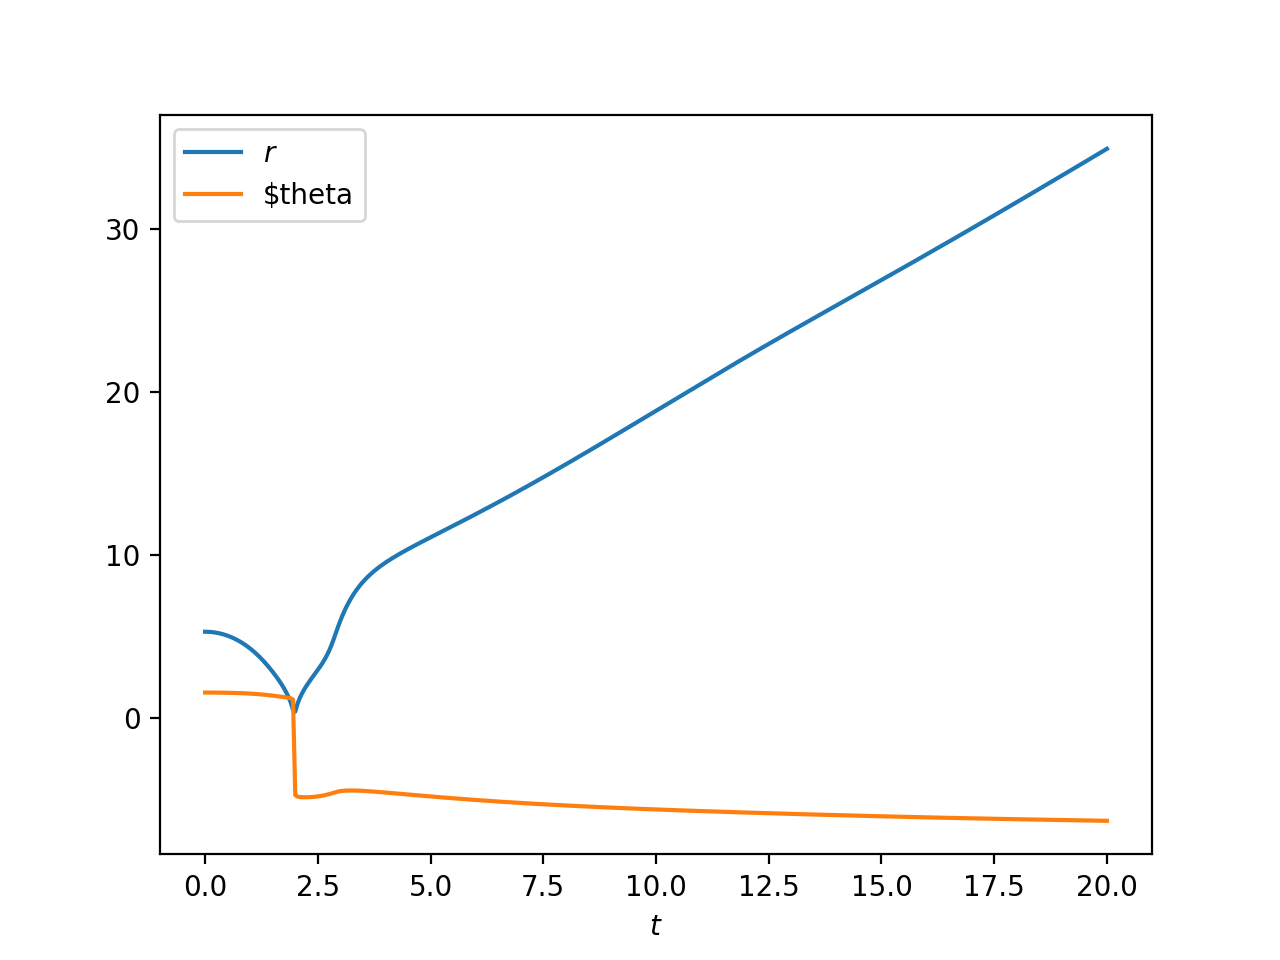

In [148]:
times = np.linspace(0, 20, 401) 
# Y0 = r, rDot, theta, thetaDot ... no starting parameters for jupiter
sol2 = negligibleMassPluto().solve((5.3, 0, np.pi/2, 0), (0,20)).plot(times, ['r','theta']);


<IPython.core.display.Javascript object>


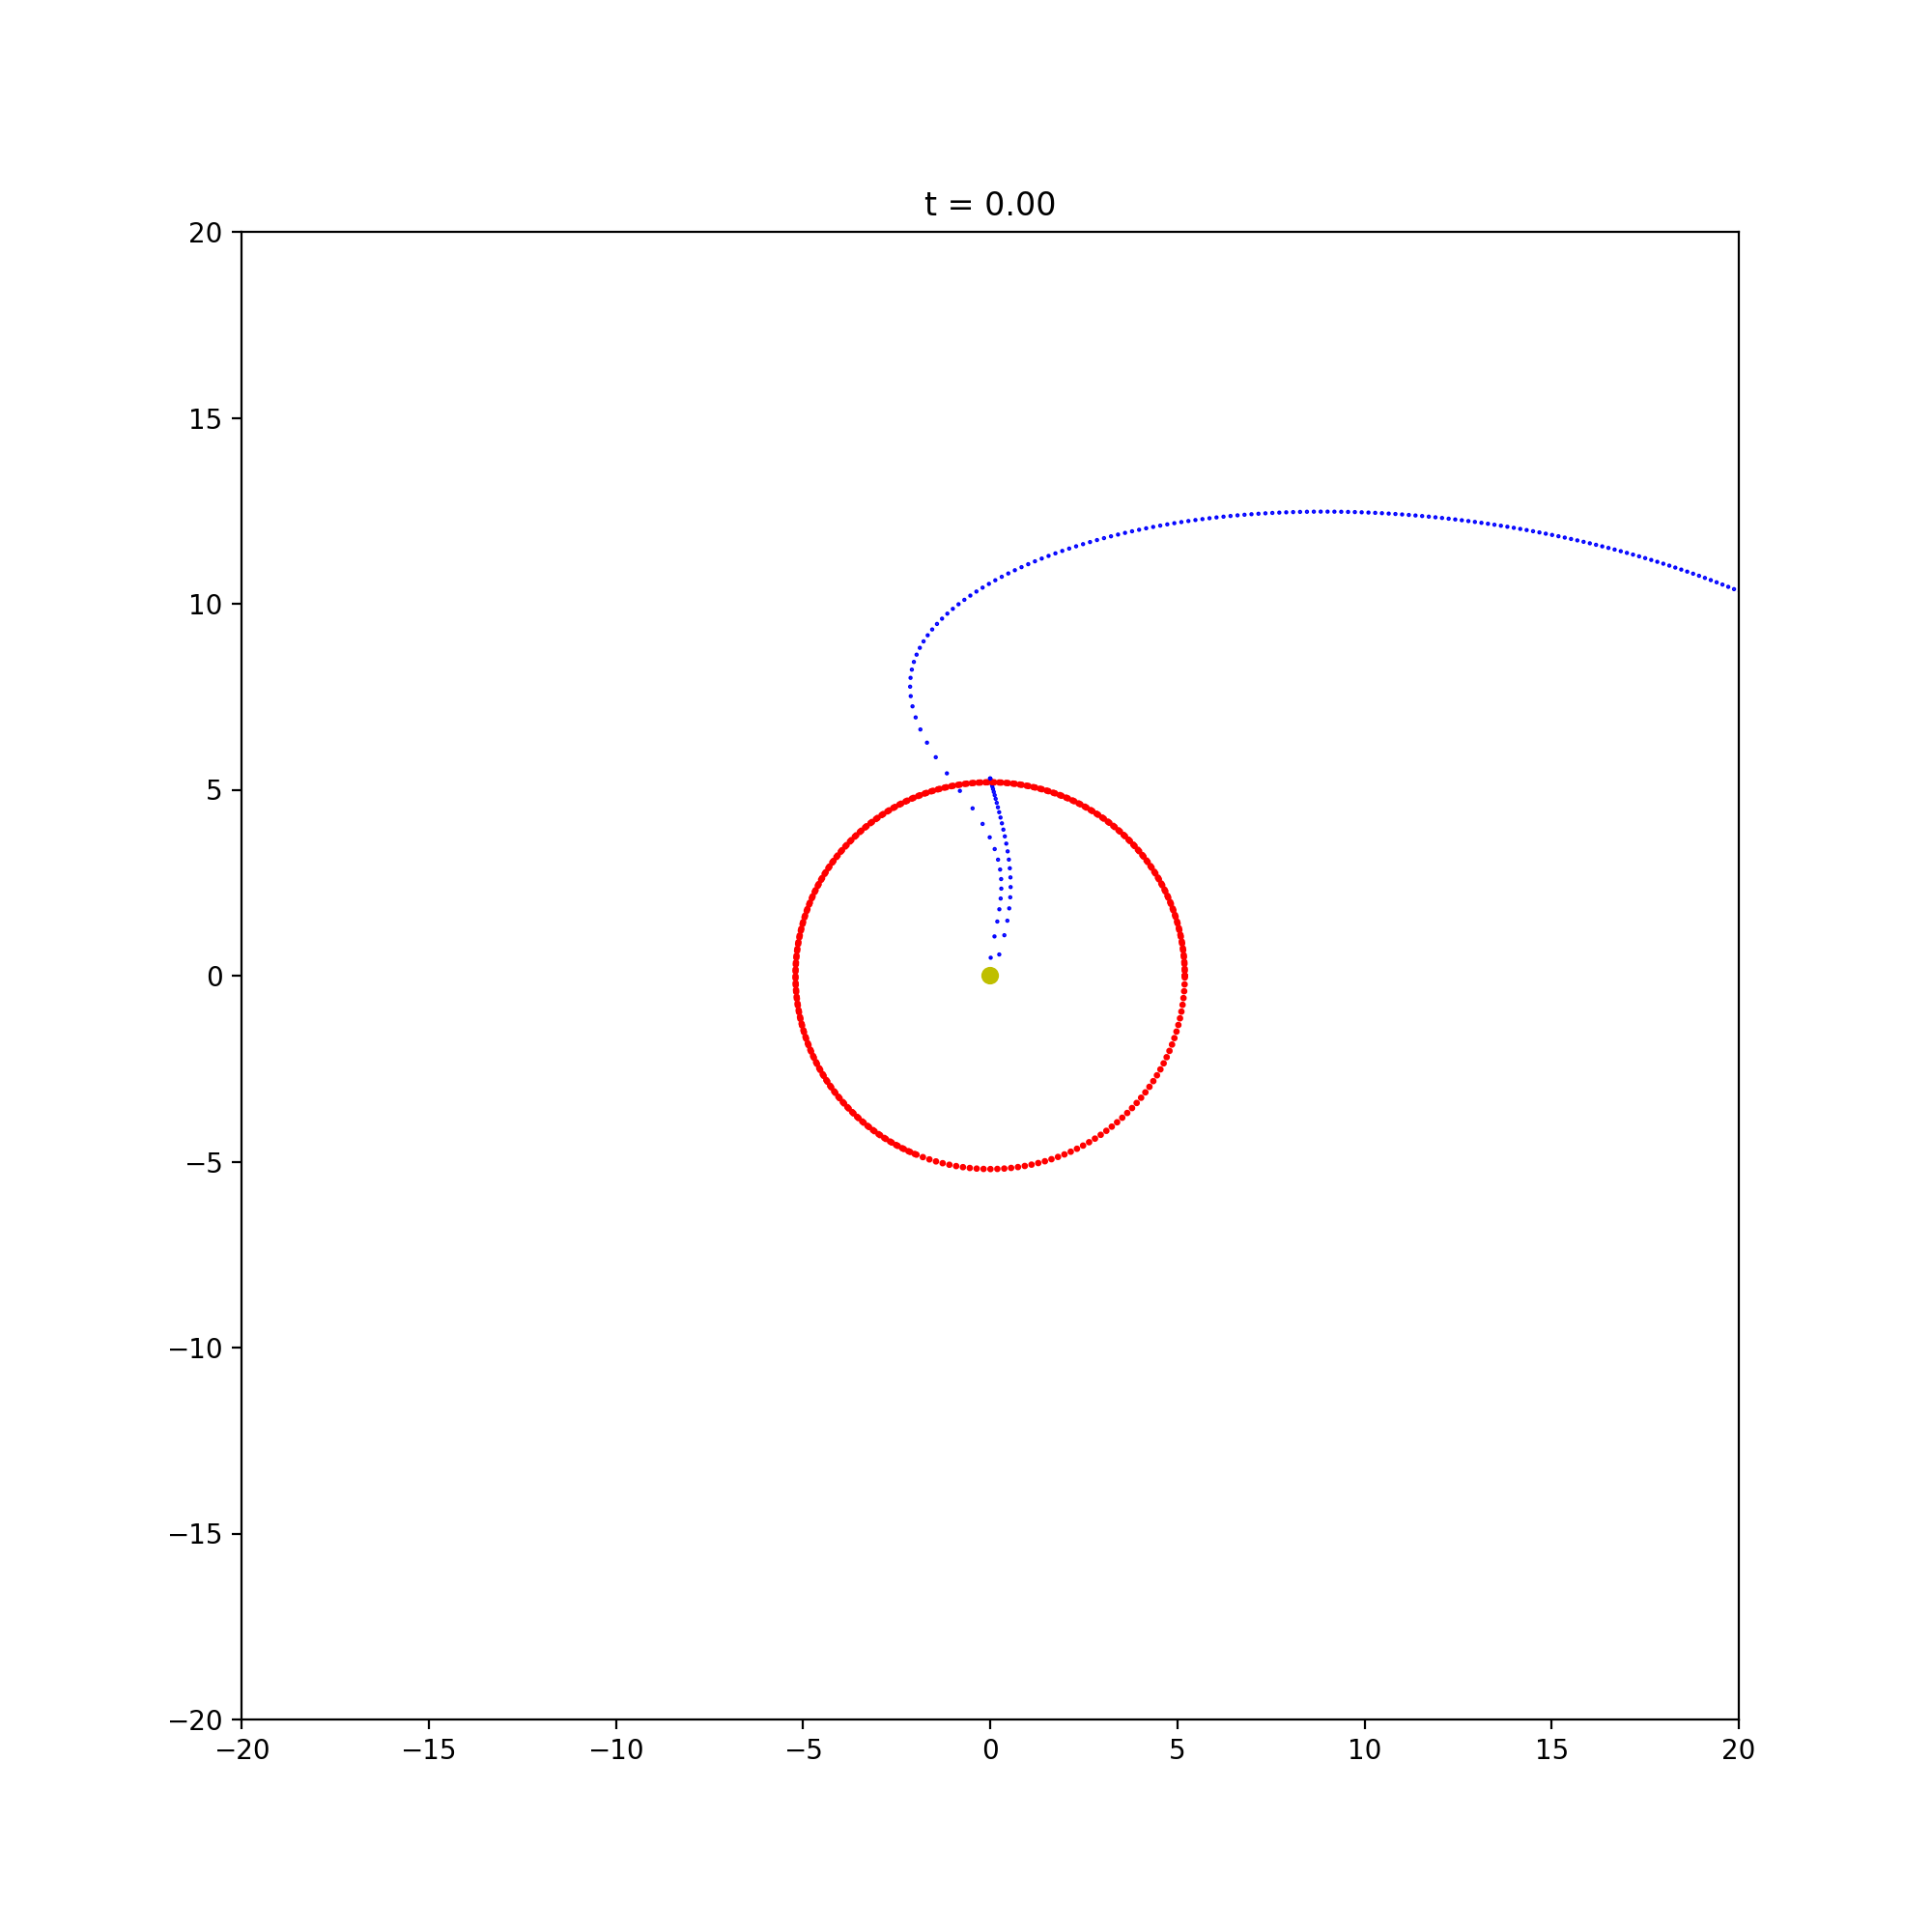

In [149]:
sol2.animate(300)

r=8.019698242016279, rDot=2.0337926848361683, theta=1.3751618954873155, thetaDot=0.7211937356443829


<IPython.core.display.Javascript object>


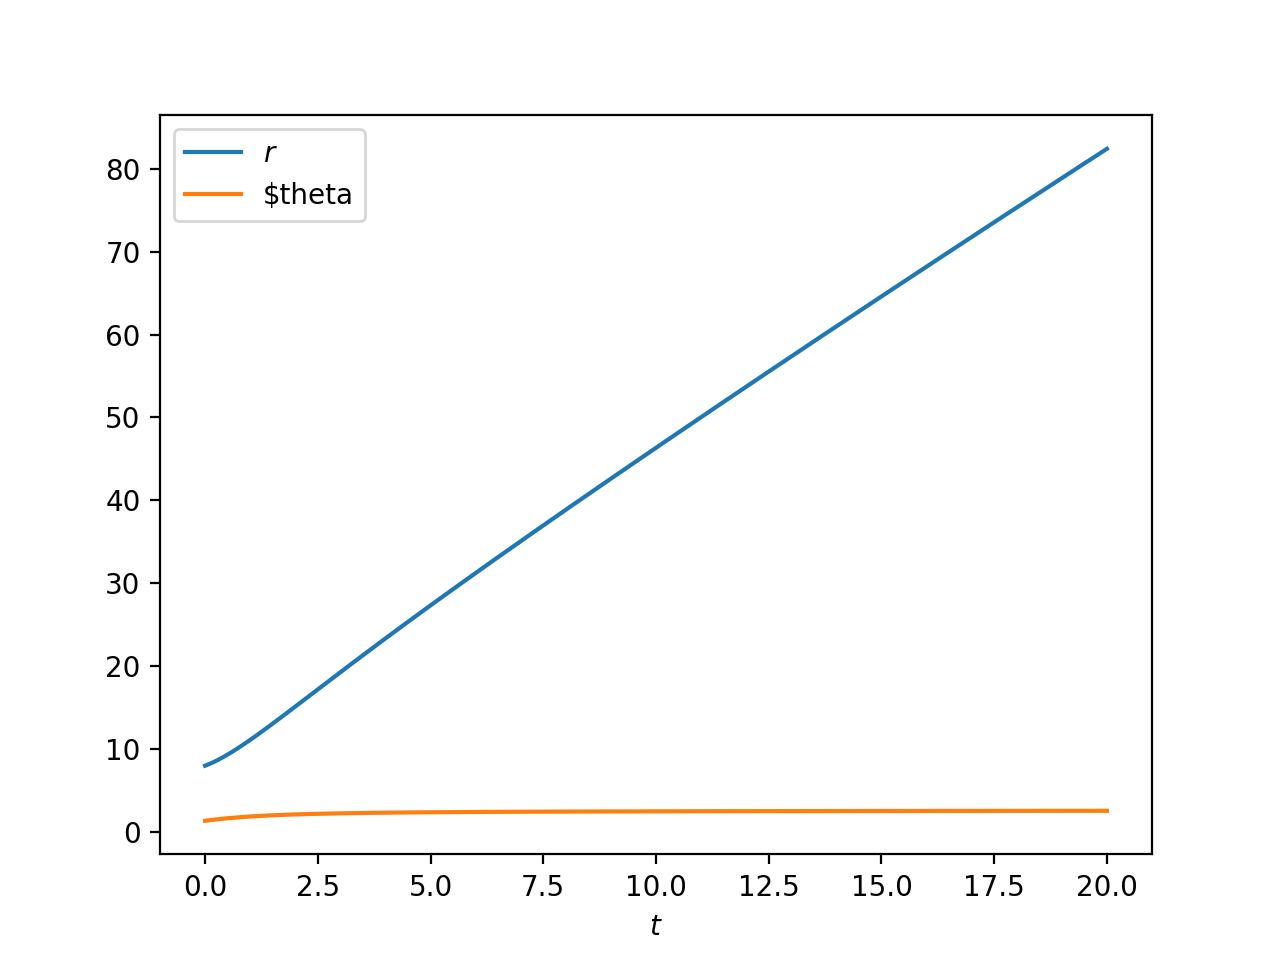

<IPython.core.display.Javascript object>


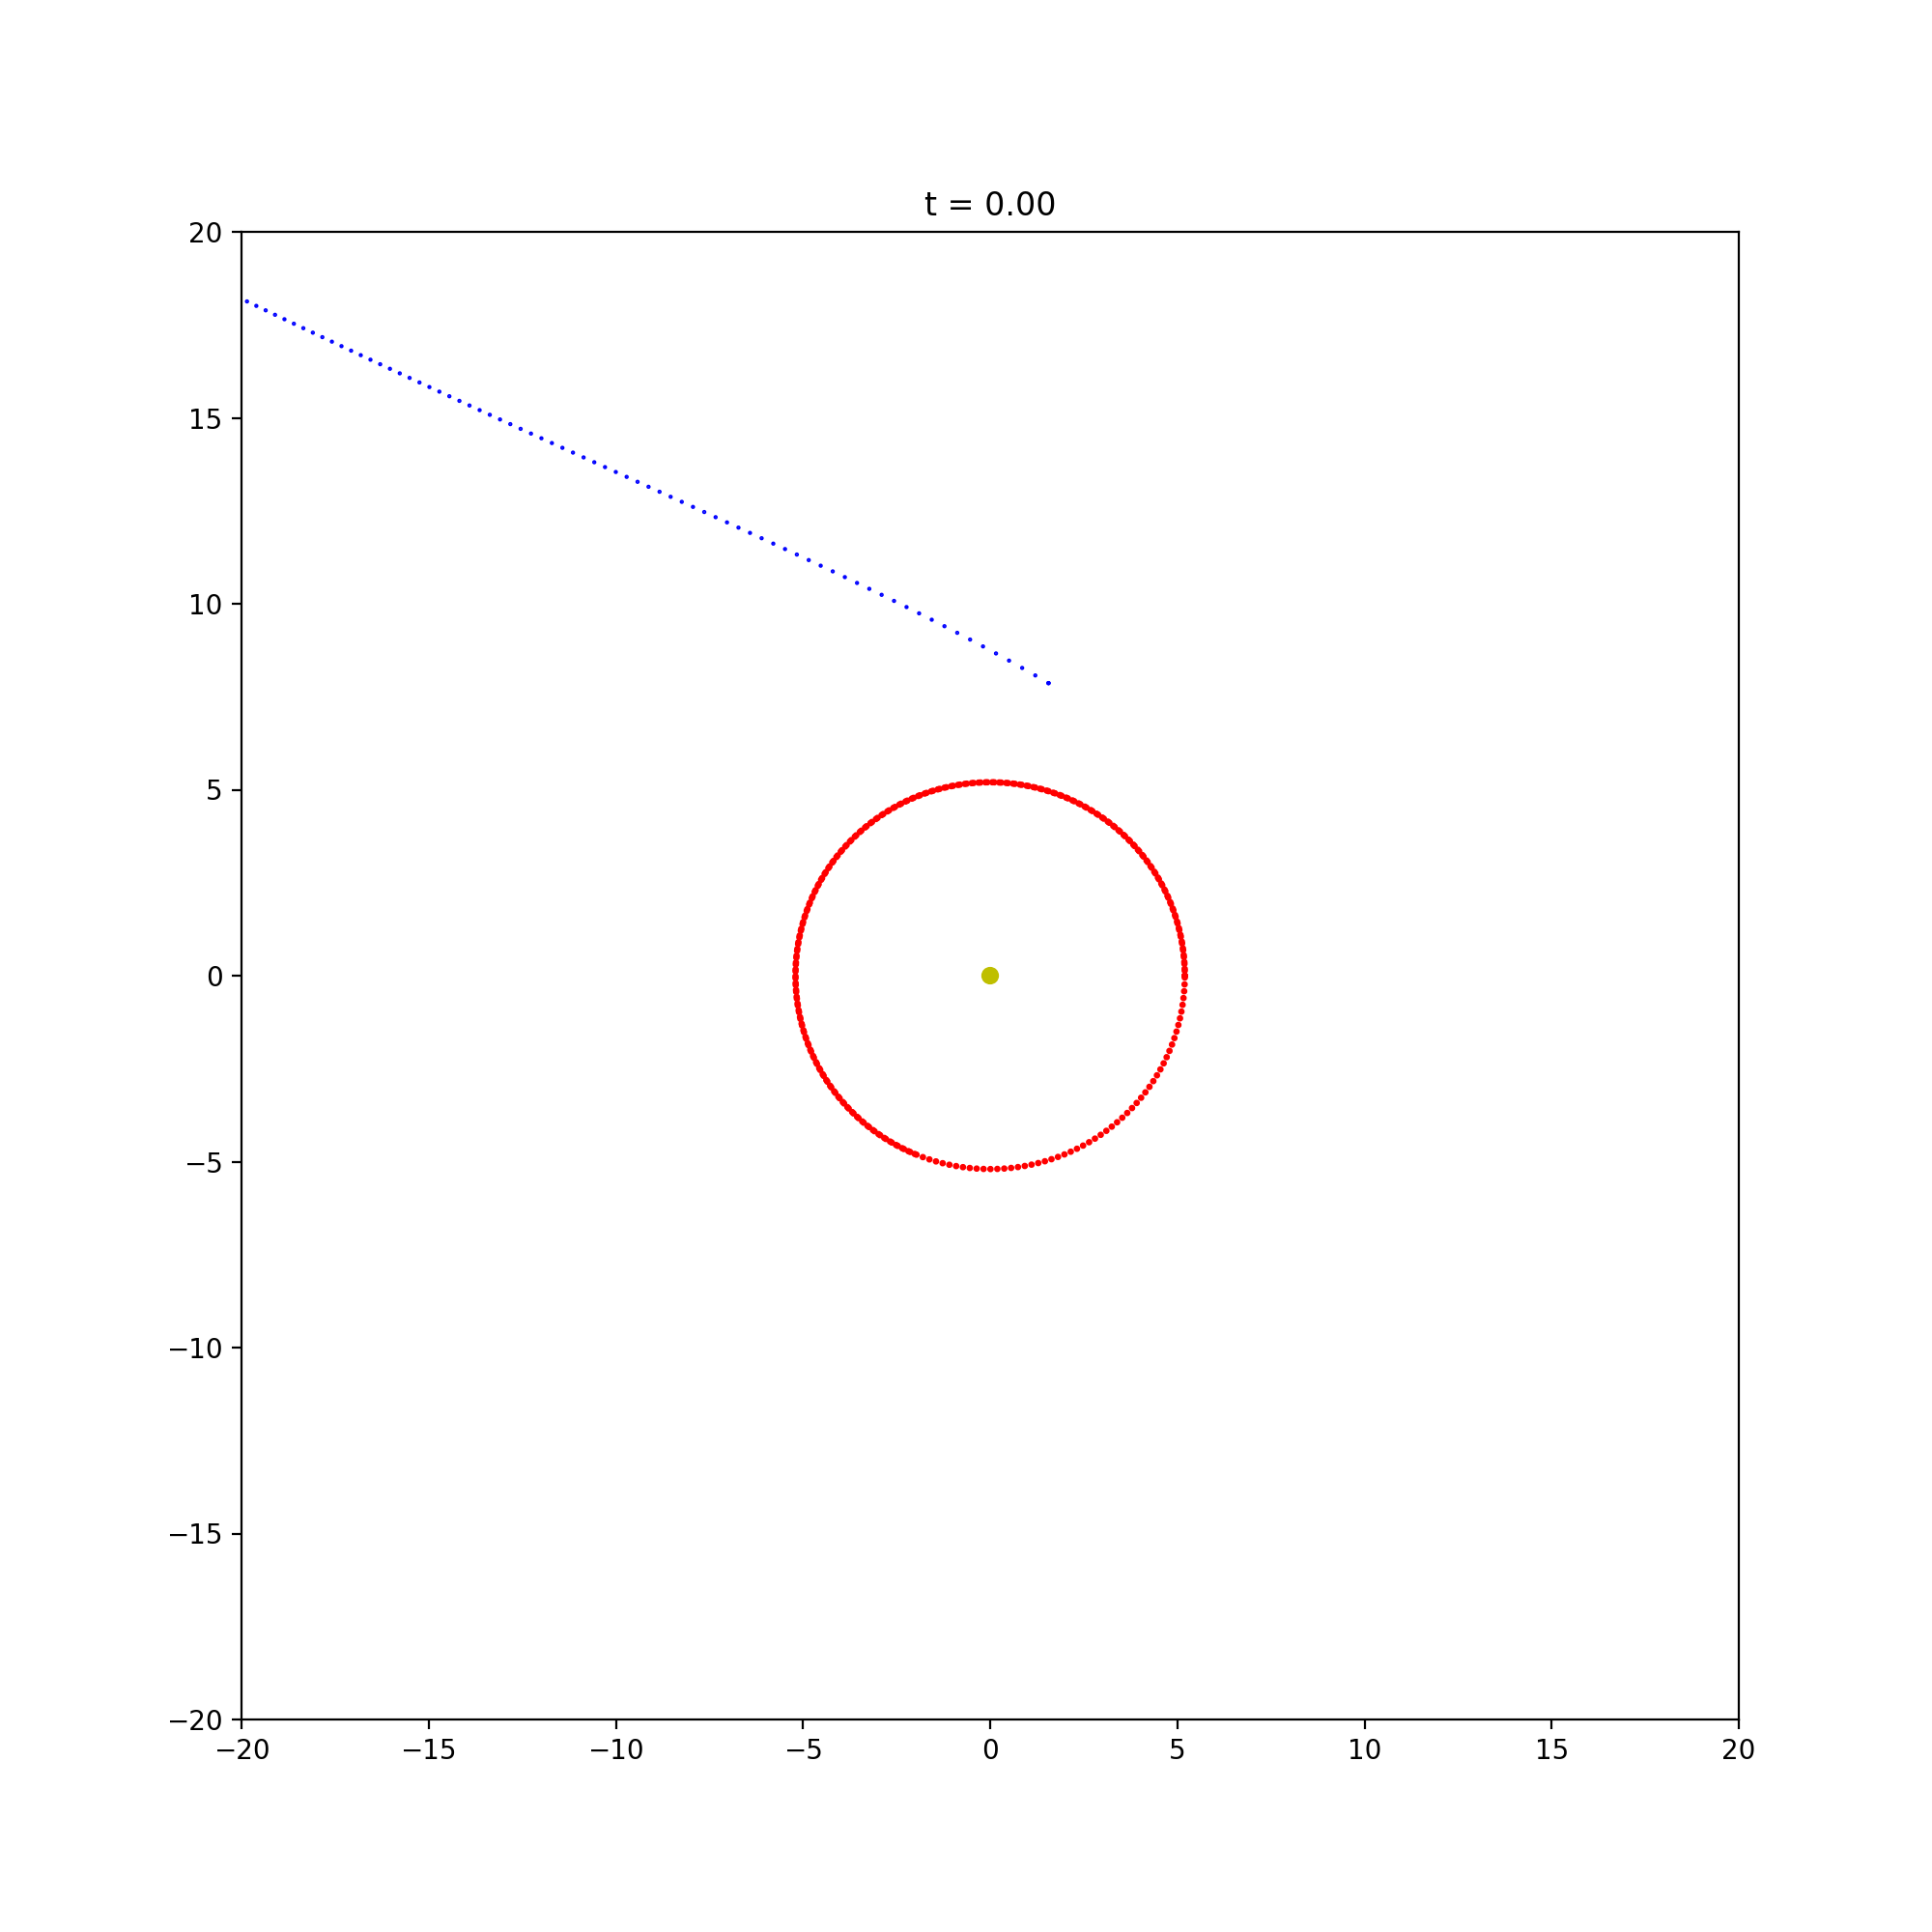

r=7.111255107192402, rDot=0.4303994230752263, theta=4.903290219434188, thetaDot=0.3878387679282058


<IPython.core.display.Javascript object>


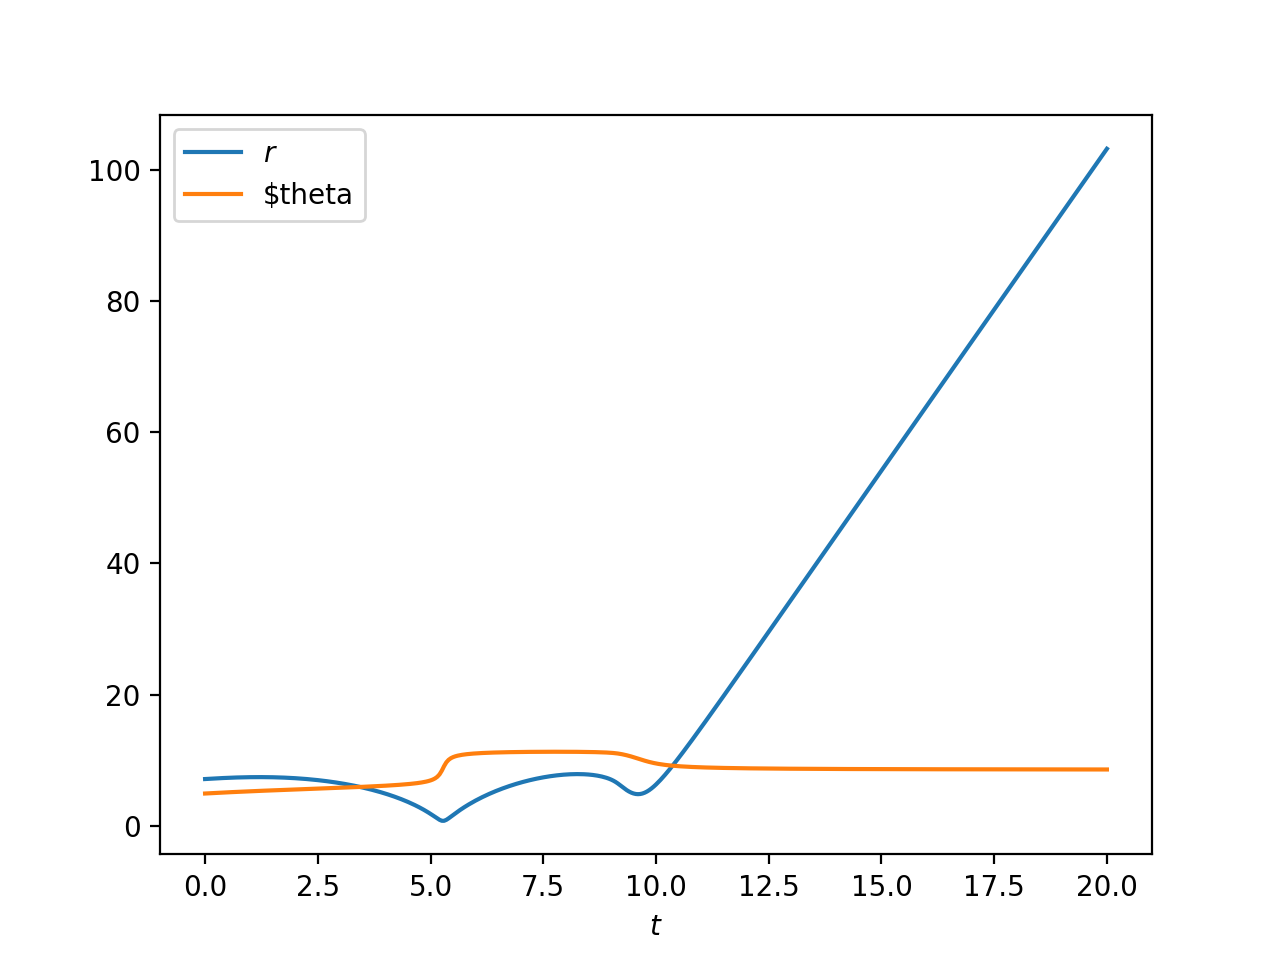

<IPython.core.display.Javascript object>


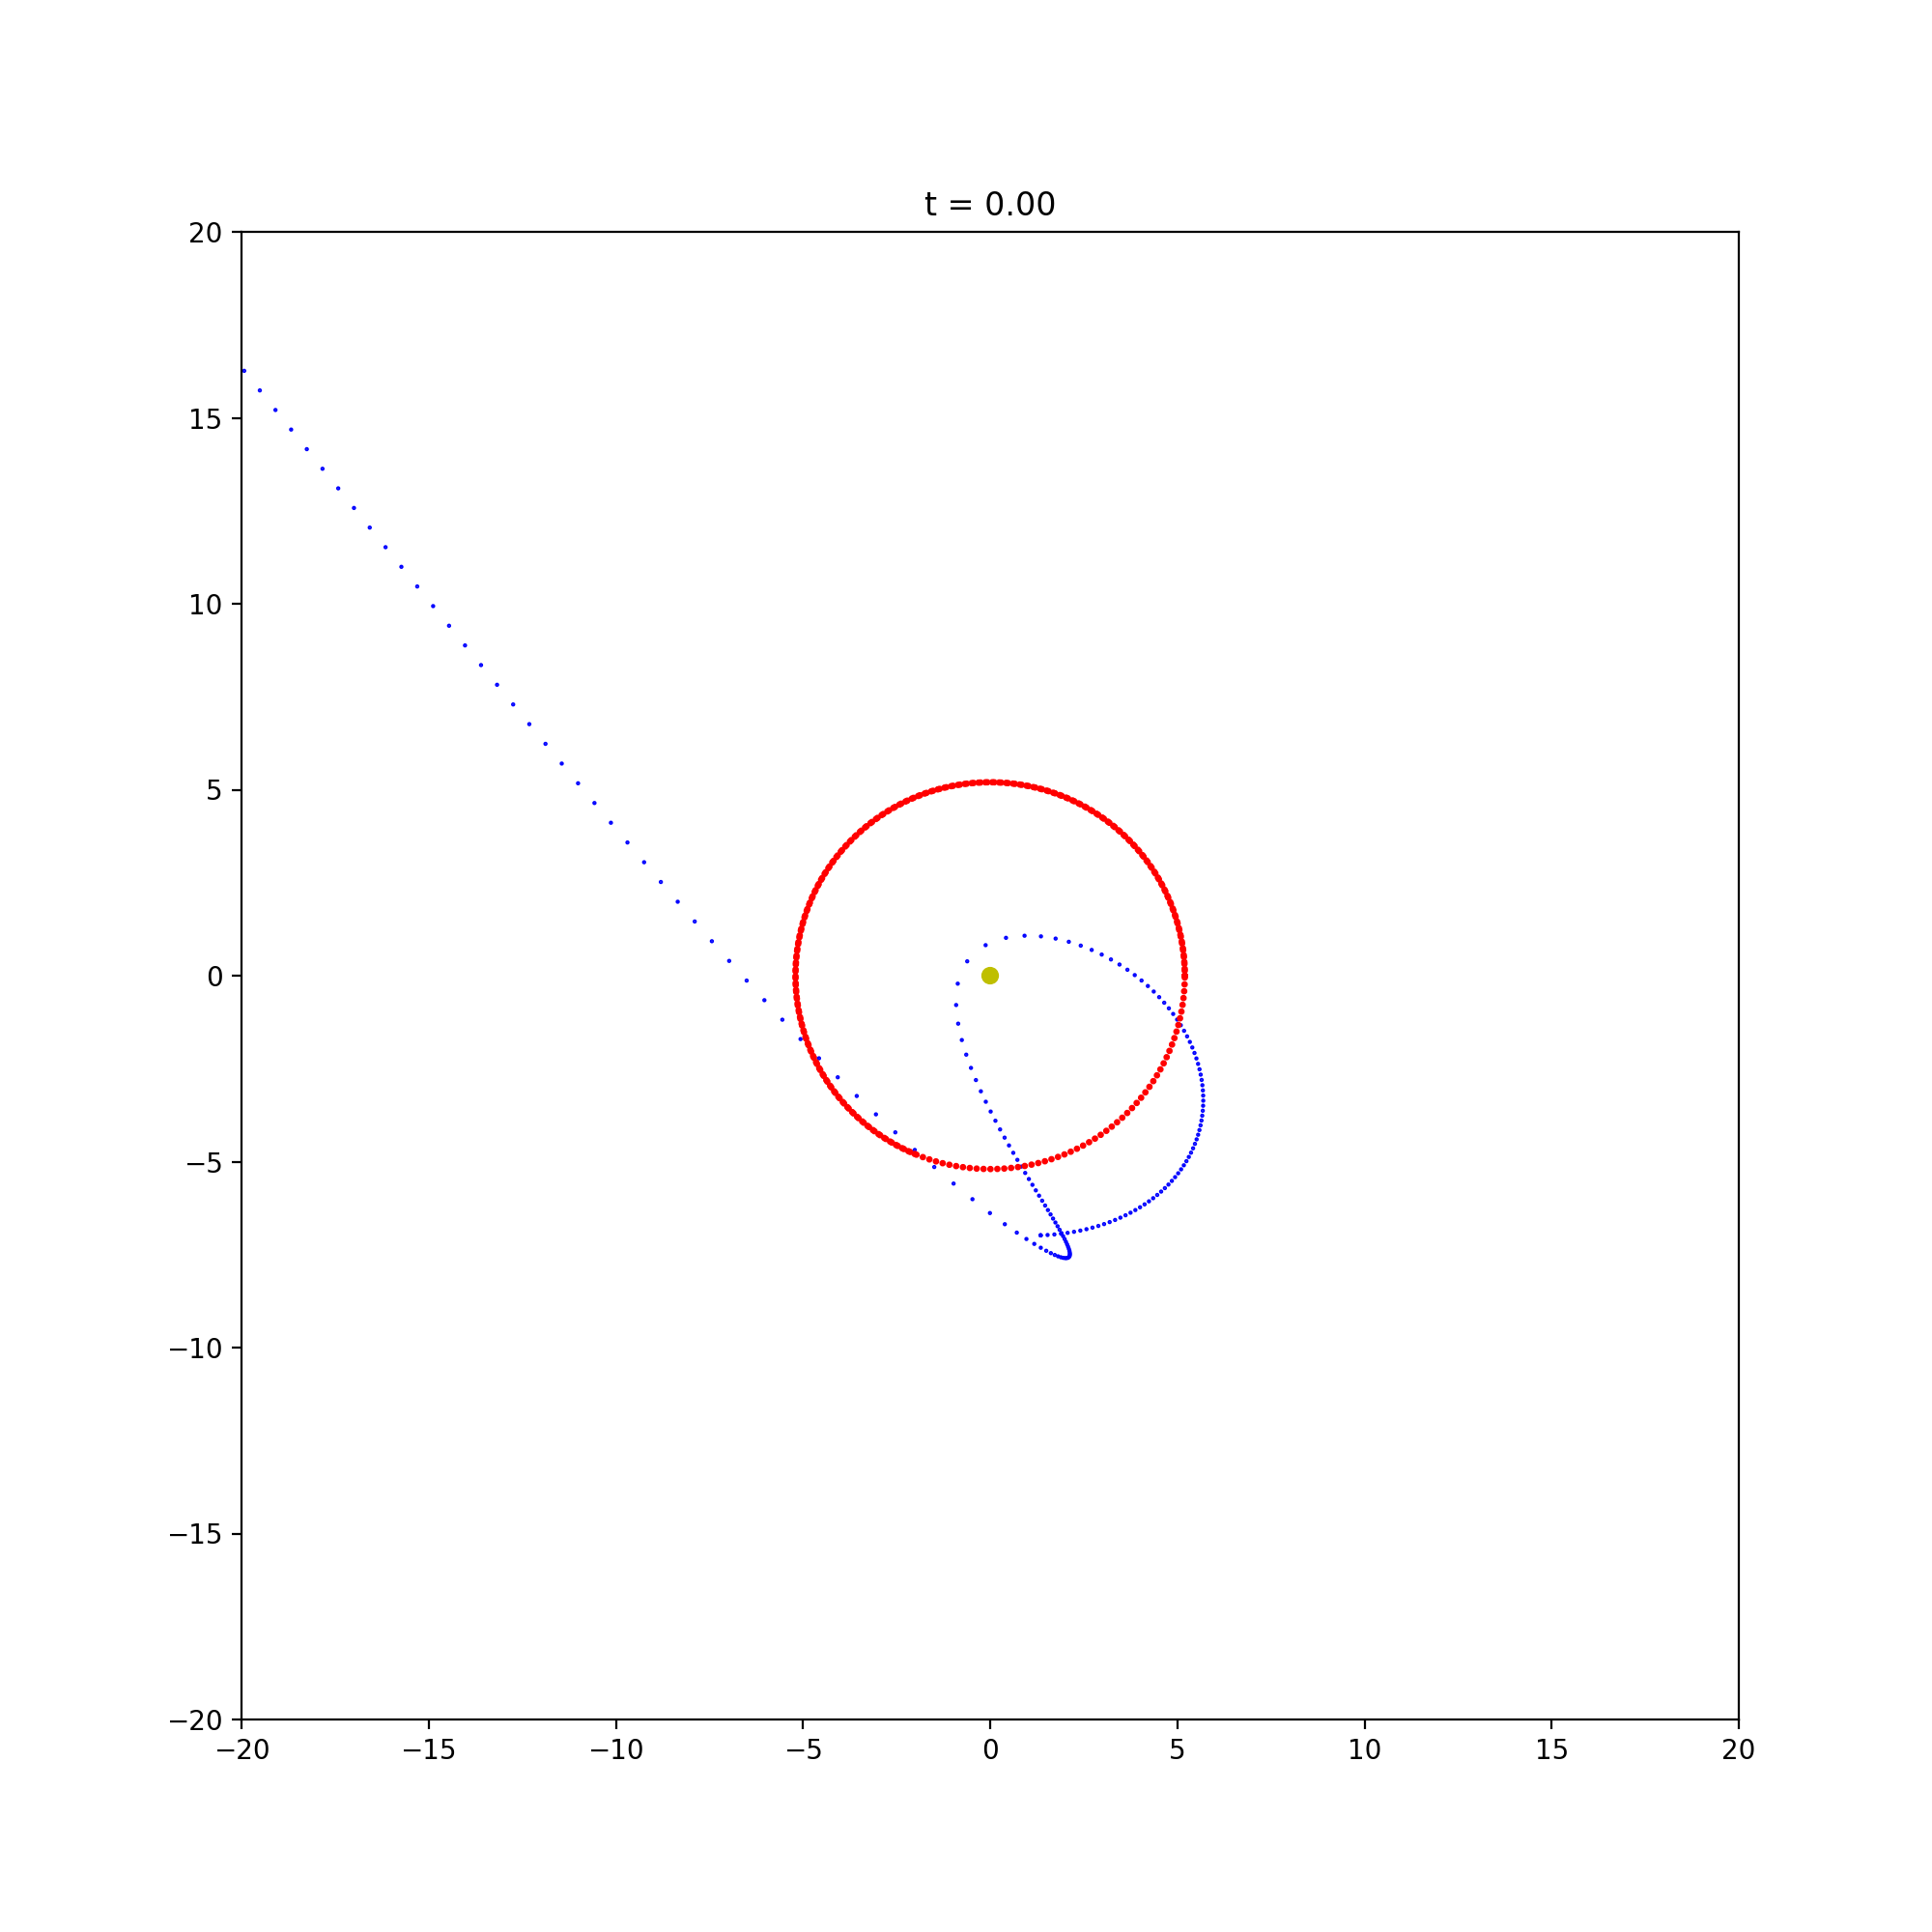

r=2.0394072189505725, rDot=1.9297020527833908, theta=3.253558407736859, thetaDot=0.46836746615397196


<IPython.core.display.Javascript object>


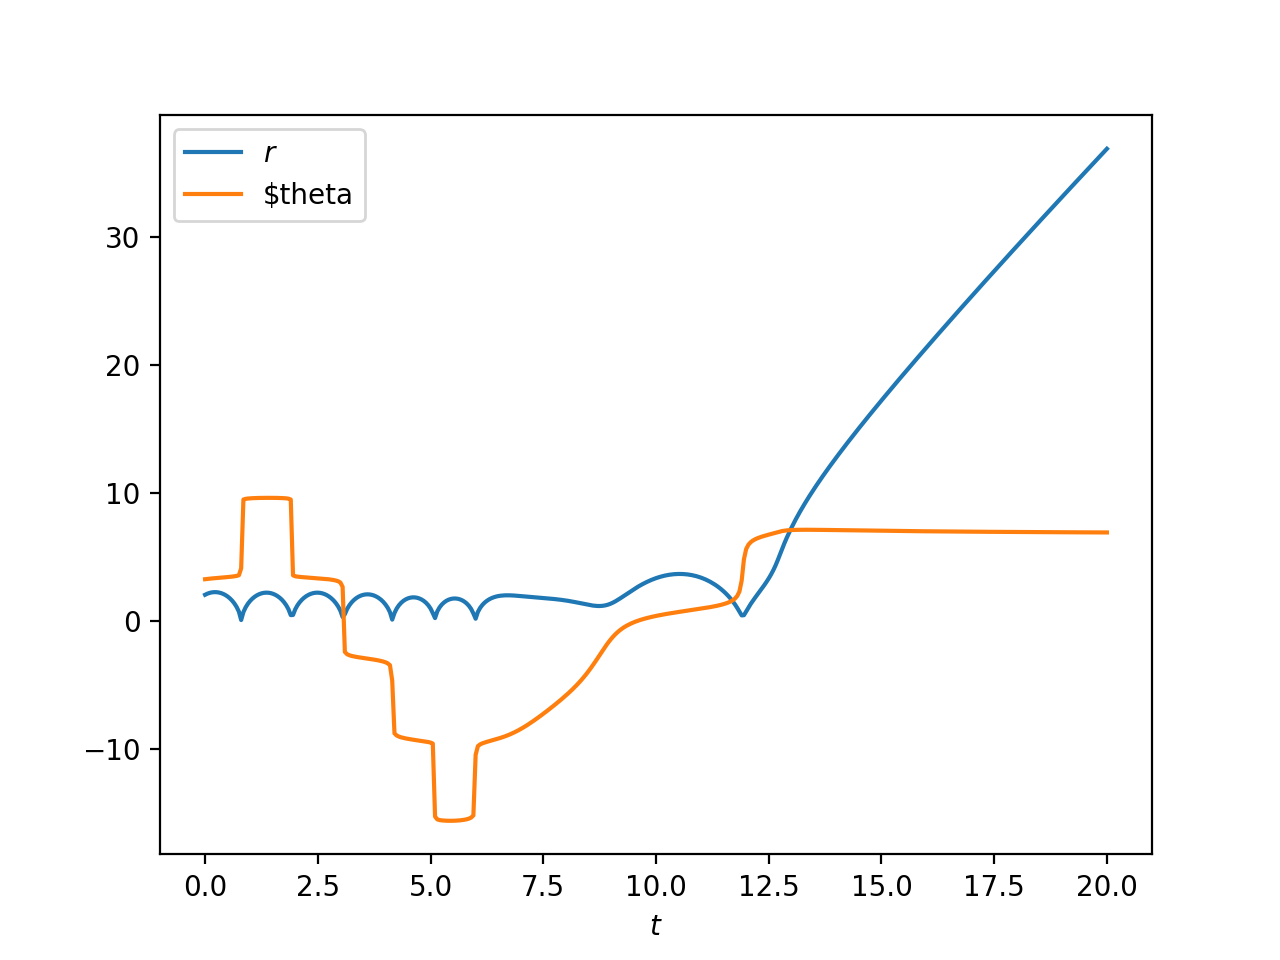

<IPython.core.display.Javascript object>


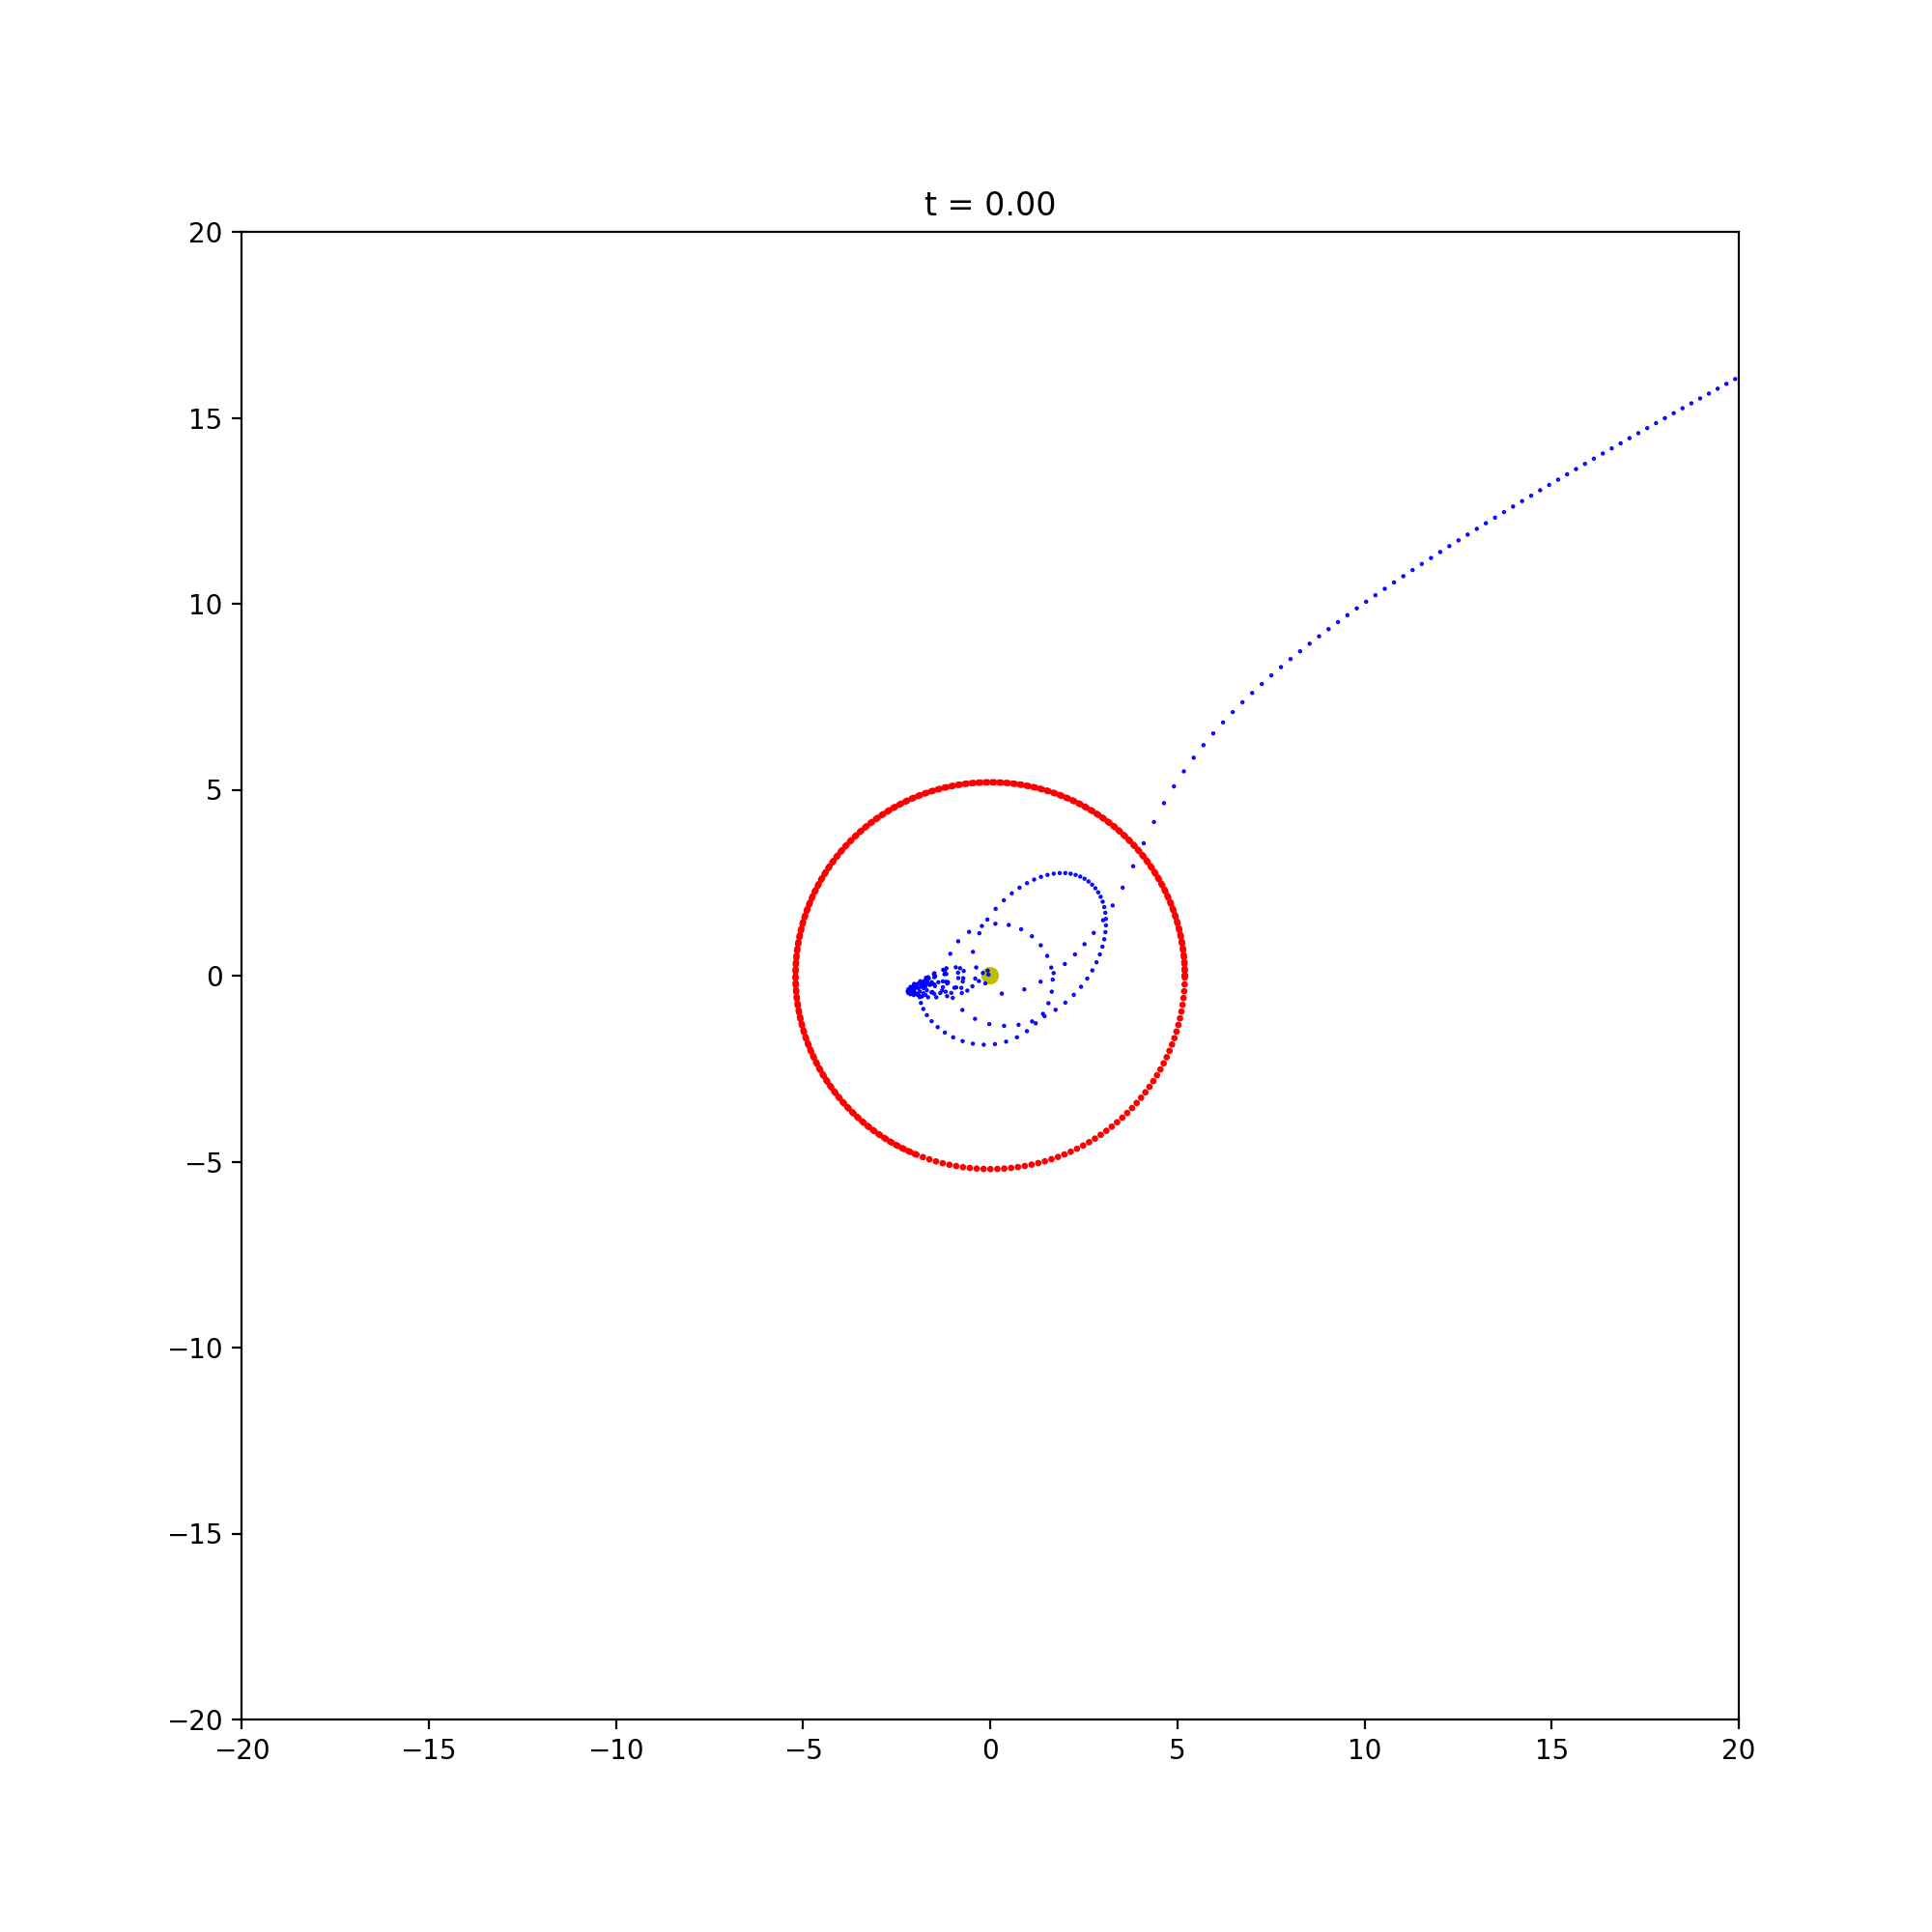

r=2.6388229924868725, rDot=0.4352366823760131, theta=3.3427313240836756, thetaDot=0.635209716504927


<IPython.core.display.Javascript object>


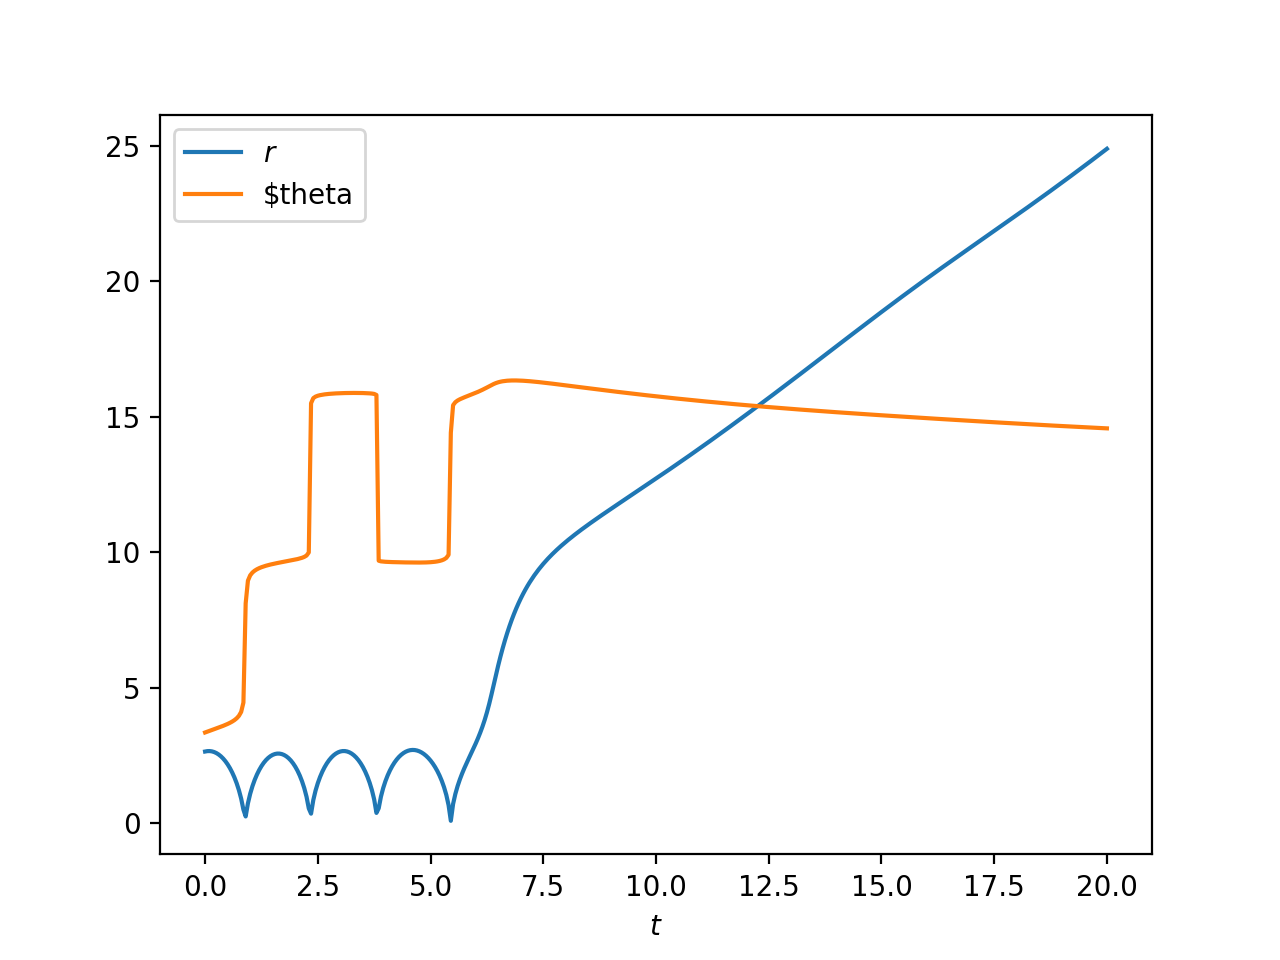

<IPython.core.display.Javascript object>


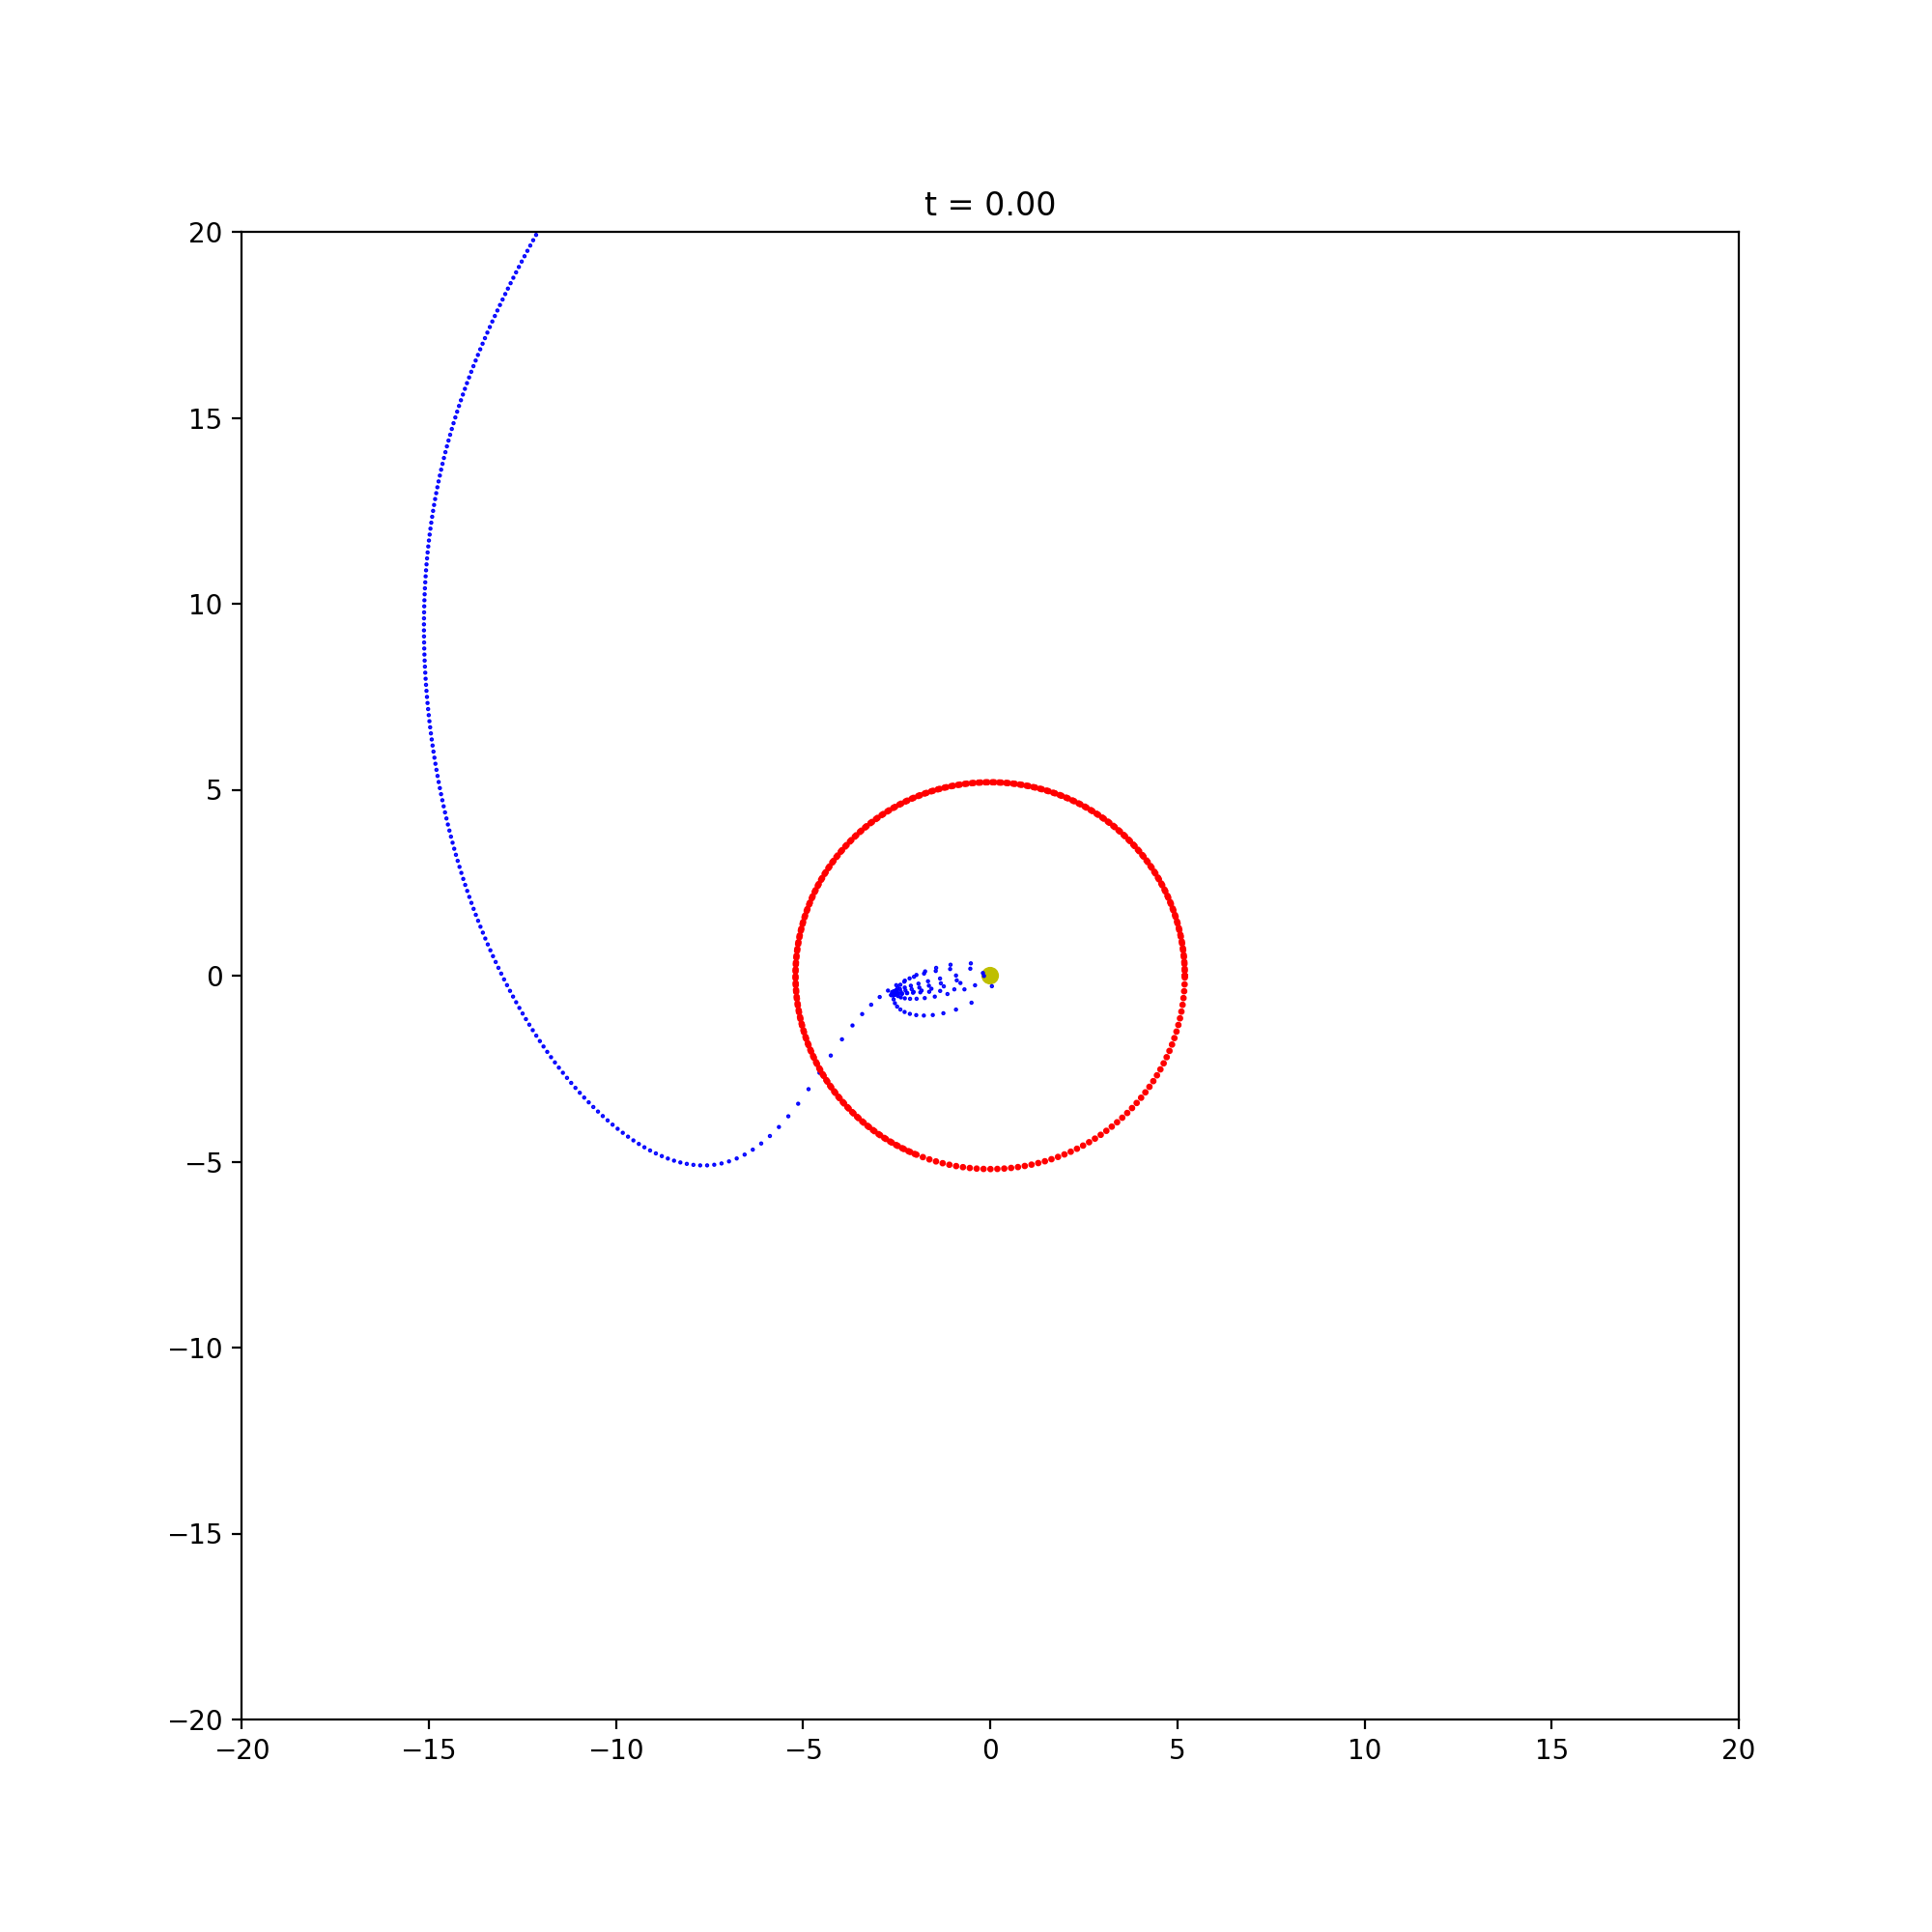

In [158]:
def randomPlutoGenerator(numSimulations):
    '''runs multiple simulations of our negligibleMassPluto class with random starting points, 
    plots and simulates results'''
    times = np.linspace(0, 20, 401) 
    for i in range(numSimulations):
        # Y0 = r, rDot, theta, thetaDot ... no starting parameters for jupiter
        r = random.uniform(0.5, 10)
        rDot = random.uniform(0, 3)
        theta = random.uniform(0, np.pi*2)
        thetaDot = random.uniform(0, 1)
        print(f"r={r}, rDot={rDot}, theta={theta}, thetaDot={thetaDot}")
        sol2 = negligibleMassPluto().solve((r, rDot, theta, thetaDot), (0,20)).plot(times, ['r','theta']);
        sol2.animate(300)

randomPlutoGenerator(4)

In [ ]:
#keeping this here in case we ever get around to incorporating the movement of the planet as a factor


class pluto(P24ASolver):
    """
    Simulate a planet orbiting the sun with another body in the same orbit.
    """

    def __init__(self, **kwargs):
        super().__init__(
            (('r', '$r$'), ('rDot', r'$\dot{r}$'),
             ('rj', '$rj$'), ('rjDot', '$rjDot$'), ('theta', r'$theta'), ('thetaDot', '$thetaDot$'), ('jTheta', '$jTheta$'), ('jThetaDot2', '$jThetaDot2$'))
        )
        # m is the small negligible mass, mj is planet
        # note, in solar masses/AU/years, GMs= 4pi^2
        self.rj = kwargs.get('rj', 5.2) # orbit radius of the planet in AU
        self.mj = kwargs.get('mj', 1) # planet mass in solar masses, 9.5e-4
        self.jInitialTheta = kwargs.get('jInitialTheta', 0) # initial planet angle
        self.r = kwargs.get('r', 5.2) # orbit radius of the small body
        self.m = kwargs.get('m', 2.71e7) # small body mass of moon in solar masses
        self.initialTheta = kwargs.get('initialTheta', np.pi/2) # initial angle of body
        self.rtol = kwargs.get('rtol', 1e-10)
        self.atol = kwargs.get('atol', 1e-10)

    def __str__(self):
        "Produce a string representation of the parameters"
        #fmt = r"$rj = {69911000:.2g}, mj = {1.898e27:.2g}, jInitialTheta = {m = {69911000:.2g}, jInitialTheta = {0:.2g}"
        # i didn't feel like doing this so i left it for now
        return fmt.format(self.R, self.m1, self.m2)

    def derivatives(self, t, Y):
        GMs = 4*np.pi**2 #big G times mass of sun
        jThetaDot = np.sqrt(GMs/(self.rj)**3) # a constant because assuming negligible mass of planetesimal
        r, rDot, rj, rjDot, theta, thetaDot, jTheta, jThetaDot2 = Y  # unpack the values, jThetaDot2 because jThetaDot is pre loaded
        sSquared = r**2 + self.rj**2 - 2*r*self.rj*np.cos(theta - jTheta)#distance between the masses squared
        theta3 = np.arccos((self.rj**2-sSquared-r**2)/(-2*np.sqrt(sSquared)*r)) #angle between sun and planet with planetesimal as axis
        rDDot = -1 * (GMs/r**2 + GMs*self.mj*np.cos(theta3)/sSquared) + r*thetaDot**2
        thetaDDot = -GMs*self.mj*np.cos(theta3)/(r*sSquared) - 2*thetaDot*rDot/r
        return [rDot, rDDot, 0, 0,
                thetaDot, thetaDDot, jThetaDot, 0]

    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize=(10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-20, 20))
        ax.set_ylim((-20, 20))

        self.shapes = []

        sun = Circle((0, 0), radius=0.2, color='y')
        ax.add_patch(sun)

        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        r, rDot, rj, rjDot, theta, thetaDot, jTheta, jThetaDot = self(t)
        while self.shapes:
            self.shapes[0].remove()

        jupiter = Circle((rj * np.cos(jTheta), rj * np.sin(jTheta)), radius=0.05, color="r")
        small_body = Circle((r * np.cos(theta), r * np.sin(theta)), radius=0.02, color="b")
        self.shape = [jupiter, small_body]
        
        # render
        self._ax.add_patch(jupiter)
        self._ax.add_patch(small_body)
        title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return jupiter, small_body, title

In [ ]:
rest = (0,0,0,0)
times = np.linspace(0, 20, 401) #y = r, rDot, rj, rjDot, theta, thetaDot, jTheta, jThetaDot2 = Y  

sol1 = pluto().solve((5.3, 0, 5.3, 0, np.pi/2, 0.6, 0, 3), (0,20)).plot(times, ['theta','rj','jTheta', 'jThetaDot2']);
